In [1]:
from PIL import Image
import os
import cv2
import cvzone
import numpy as np
import math
import shutil 
import re

## PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F 
import torch.utils.data as data 
from torch.utils.data import DataLoader, Dataset
import torch.optim as optim

from torchvision import transforms, datasets, models

## Matplotlib
import matplotlib.pyplot as plt

## sklearn e seaborn
from sklearn.metrics import precision_recall_curve, f1_score, confusion_matrix
from sklearn.preprocessing import label_binarize

import seaborn as sns

## Yolo
from ultralytics import YOLO

import scipy.linalg
from scipy.optimize import linear_sum_assignment

In [3]:
def set_seed(seed):
    np.random.seed(seed)
    torch.manual_seed(seed)


set_seed(42)

device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")

### Preparazione dei dati
Il dataset originario era composto da 26067 immagini, mentre per motivi logistici in questo notebook è stato ridotto a 9014 immagini e 11 classi (invece delle 32 originarie). Per carciare le immagini usiamo la funzionalità `ImageLoader` presente in Pytorch che permette di estrarre tutte le immagini presenti in una cartella (e nelle sue sottocartelle) e assegna come lable a tali immagini il nome della cartella stessa.

Il nuovo dataset è composto da 16181 immagini

In [3]:
path = "../../archive"

fish_dir = "Fish"
person_dir = "Person"
octopus_dir = "Octopus"
whale_dir = "Whale"
turtle_dir = "Turtle"

person_dirs = ["ArmyDiver3"]
fish_dirs = ["JerkbaitBites", "FishFollowing"]
whale_dirs = ["WhaleDiving"]
octopus_dirs = ["Octopus1"]
turtle_dirs = ["SeaTurtle1"]

# Create directories
os.makedirs(person_dir, exist_ok=True)
os.makedirs(fish_dir, exist_ok=True)
os.makedirs(whale_dir, exist_ok=True)
os.makedirs(turtle_dir, exist_ok=True)
os.makedirs(octopus_dir, exist_ok=True)


def numerical_sort(value):
    numbers = re.findall(r'\d+', value)
    return int(numbers[0])

def merge_images_and_labels(class_dir, directories):
    index = 1
    bbox_destination = class_dir + "/" + "groundtruth_rect.txt"
    # We make sure that the destination file is empty
    open(bbox_destination, 'w').close()

    destination = open(bbox_destination, "a")
    for filename in directories:
        folder_path = path + "/" + filename
        # Extract bounding boxes
        bbox_path = folder_path + "/" + "groundtruth_rect.txt"

        f = open(bbox_path, "r")
        content = f.read()

        destination.write(content)

        f.close()
        
        # Extract images
        sub_directory = folder_path + "/img"          
        entries = sorted(os.listdir(sub_directory), key=numerical_sort)

        for file in entries:
            
            image = os.path.join(sub_directory, file)

            new_filename = f"{index}.jpg"
            destination_folder = class_dir + "/img"
            destination_path = os.path.join(destination_folder, new_filename)
            shutil.copy(image, destination_path)

            index += 1

    destination.close()


In [4]:
merge_images_and_labels(turtle_dir, turtle_dirs)
merge_images_and_labels(fish_dir, fish_dirs)
merge_images_and_labels(octopus_dir, octopus_dirs)
merge_images_and_labels(person_dir, person_dirs)
merge_images_and_labels(whale_dir, whale_dirs)

In [6]:
dataset_path = "../archive"

# Facciamo override della classe originaria perchè vogliamo estrarre
# anche l'indice dell'immagine, questo servirà dopo per la preparazione
# del dataset nel formato richiesto per l'addestramento di Yolov8
# (nello specifico l'indice ci serve per associare ad ogni immagine il suo bounding box)

class ImageFolderWithIndices(datasets.ImageFolder):
    def __getitem__(self, index):
        
        image, label = super().__getitem__(index)

        path = self.imgs[index][0]
        filename = os.path.basename(path)

        str_num = ''
        for elem in filename:
            if elem.isdigit():
                str_num += elem

        num = (int) (str_num)
    
        return image, label, num
    
dataset = ImageFolderWithIndices(root=dataset_path)
print(len(dataset))
print(dataset.classes)

'''
    Il dataset viene suddiviso nel modo seguente:
        - 80% training_set
        - 10% validation_set
        - 10% test_set
'''

train_set, val_set, test_set = torch.utils.data.random_split(dataset, [4908, 613, 613])


6134
['Fish', 'Octopus', 'Person', 'Turtle', 'Whale']


#### Estrazione dei bounding boxes

In [7]:
''' 
Il bounding box ritornato da questo script avrà la seguente forma:
    bbox = [x_top_left, y_top_left, width, height, index], 
    dove index è l'indice dell'immagine nella cartella in cui è salvata,
    questo serve per ricreare la corrispondenza fra immagine e lable
'''

bounding_boxes = []

entries = sorted(os.listdir(dataset_path))
for folder in entries:
    sub_directory = os.path.join(dataset_path, folder)
    tensor_list = []

    for filename in os.listdir(sub_directory):
        if filename.endswith("groundtruth_rect.txt"):
            path = os.path.join(sub_directory, filename)
            f = open(path, "r")
            lines = f.readlines()
            len_file = len(lines)

            for i in range(len_file):
                line = lines[i].split()
                floates = [float(x) for x in line]
                index = (float)(i)
                floates.append(index)
                coordinates = torch.tensor(floates)
                tensor_list.append(coordinates)
        
    bounding_boxes.append(tensor_list)


#### Preparazione del dataset per l'addestramento di YOLOv8 e ResNet18

In [4]:
dataset_dir = "datasets/dataset"
resnet_dir = "resnet_dir"

# creazione delle directory per Yolov8

image_dirs = {
    "train" : os.path.join(dataset_dir, "images/train"),
    "val": os.path.join(dataset_dir, "images/val"),
    "test": os.path.join(dataset_dir, "images/test")
}

label_dirs = {
    "train": os.path.join(dataset_dir, "labels/train"),
    "val": os.path.join(dataset_dir, "labels/val"),
    "test": os.path.join(dataset_dir, "labels/test")
}

# Creazione delle directory per ResNet18

dirs = {
    "train" : os.path.join(resnet_dir, "train"),
    "val" : os.path.join(resnet_dir, "val"),
    "test" : os.path.join(resnet_dir, "test")
}

# Creazione delle cartelle

for dir_path in image_dirs.values():
    os.makedirs(dir_path, exist_ok=True)
for dir_path in label_dirs.values():
    os.makedirs(dir_path, exist_ok=True)
for dir_path in dirs.values():
    os.makedirs(dir_path, exist_ok=True)

# Salvataggio delle delle immagini e dei bounding boxes

def save_images_and_labels(data, dataset_type):
    image_dir = image_dirs[dataset_type]
    label_dir = label_dirs[dataset_type]
    cropped_image_dir = dirs[dataset_type]

    for image, label, index in data:
        img_save_path = os.path.join(image_dir, f"{index}_{label}.jpg")
        image.save(img_save_path)

        width = image.width
        height = image.height

        bounding_box = bounding_boxes[label][index-1]
        bbox_width = bounding_box[2]
        bbox_height = bounding_box[3]
        
        class_id = label

        label_save_path = os.path.join(label_dir, f"{index}_{label}.txt")
        with open(label_save_path, 'w') as f:

            # normalizziamo il bbox

            x_center = (bounding_box[0] + bbox_width/2) / width
            y_center = (bounding_box[1] + bbox_height/2) / height
            b_width = bbox_width / width
            b_height = bbox_height / height

            f.write(f"{class_id} {x_center} {y_center} {b_width} {b_height}\n")

        # Ritagliamo le immagini tenendoci solo la parte individuata dai bounding boxes

        bbox_width = float(bbox_width)
        bbox_height = float(bbox_height)
        
        x_min, y_min = round(float(bounding_box[0]), 1), round(float(bounding_box[1]), 1)
        x_max = round(float(x_min + bbox_width), 1)
        y_max = round(float(y_min + bbox_height), 1)

        # Check che verifica che non si esca dai bordi dell'immagine o che non ci siano bounding boxes con 
        # altezza o spessore nullo
        if x_min < 0 or y_min < 0 or x_max >= width or y_max >= height or x_max - x_min <= 0 or y_max - y_min <= 0:
            continue
        
        cropped_image = image.crop((x_min, y_min, x_max, y_max))
        cropped_save_path = os.path.join(cropped_image_dir, f"{index}_{label}.jpg")
        cropped_image.save(cropped_save_path)
        

In [9]:
save_images_and_labels(train_set, "train")
save_images_and_labels(test_set, "test")
save_images_and_labels(val_set, "val")

### Yolov8

In [2]:
model = YOLO("best.pt")     # cambiare con 'yolov8n.pt' in fase di addestramento

In [ ]:
# Addestramento del modello
result = model.train(data="file.yaml", epochs=15, batch=32)

#### Risultati

<img src="last_run/P_curve.png" alt="P_curve" width="500" height="400"/> <img src="last_run/PR_curve.png" alt="PR_curve" width="500" height="400"/> <img src="last_run/confusion_matrix.png" alt="confusion_matrix" width="500" height="400"/>

#### Tracking con Yolov8

In [ ]:
res1 = model.track(source="Tracking_test/Ballena/Ballena.mp4", conf=0.5, iou=0.6, show=True)

In [ ]:
res2 = model.track(source="Tracking_test/SeaDiver/SeaDiver.mp4", conf=0.3, iou=0.5, show=True)

In [ ]:
res3 = model.track(source="Tracking_test/Octopus2/Octopus2.mp4", conf=0.5, iou=0.6, show=True)

#### Addestramento di ResNet18 per l'estrazione delle feature dai bounding boxes

Nelle prime due celle di codice estraiamo le immagini al fine di calcolare la loro media e deviazione standard per poterle normalizzare in modo che complessivamente la media e la deviazione standard su tutto il dataset siano approssimativamente 0 e 1.

In [5]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

tmp_dataset = datasets.ImageFolder(root=resnet_dir, transform=transform)

In [6]:
# Andiamo a calcolare la media e la deviazione standard per 
# poter poi normalizzare le immagini

dataset_size = len(tmp_dataset)

DATA_MEAN = 0.0
var = 0.0

for i in range(dataset_size):
    image, _ = tmp_dataset[i]
    DATA_MEAN += image.mean(dim=(1, 2))
    var += image.var(dim=(1, 2))
    

DATA_MEAN /= dataset_size
DATA_STD = torch.sqrt(var/dataset_size)

print(f"Mean: {DATA_MEAN}")
print(f"std: {DATA_STD}")

""" 
Mean: tensor([0.2393, 0.3921, 0.4967])
std: tensor([0.1353, 0.1571, 0.1557])
"""

Mean: tensor([0.2393, 0.3921, 0.4967])
std: tensor([0.1353, 0.1571, 0.1557])


' \nMean: tensor([0.2158, 0.3814, 0.4362])\nstd: tensor([0.1290, 0.1234, 0.1188])\n'

In [4]:
test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.2393, 0.3921, 0.4967], [0.1353, 0.1571, 0.1557])
])

train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.2393, 0.3921, 0.4967], [0.1353, 0.1571, 0.1557])
])

train_dataset_path = "resnet_dir/train"
val_dataset_path = "resnet_dir/val"
test_dataset_path = "resnet_dir/test"

class CostumImageDataset(Dataset):
    def __init__(self, image_folder, transform=None):
        self.image_folder = image_folder
        self.image_filenames = os.listdir(image_folder)
        self.transform = transform

    def __len__(self):
        return len(self.image_filenames)
    
    def __getitem__(self, idx):
        img_path = os.path.join(self.image_folder, self.image_filenames[idx])
        image = Image.open(img_path)
        filename = self.image_filenames[idx].split('_')
        category = filename[1].split('.')
        label = int(category[0])

        if self.transform:
            image = self.transform(image)
        
        return (image, label)
    

train_dataset = CostumImageDataset(train_dataset_path, train_transform)
val_dataset = CostumImageDataset(val_dataset_path, test_transform)
test_dataset = CostumImageDataset(val_dataset_path, test_transform)

train_loader = data.DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = data.DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = data.DataLoader(test_dataset, batch_size=32, shuffle=False)


In [12]:
imgs, _ = next(iter(train_loader))
print("Batch mean", imgs.mean(dim=[0,2,3]))
print("Batch std", imgs.std(dim=[0,2,3]))

Batch mean tensor([-0.1125, -0.1609, -0.2104])
Batch std tensor([1.2498, 1.5425, 1.6368])


In [ ]:
def train_resnet18(model, optimizer, data_loader, loss_module, num_epochs):
    model.train()

    # Parallelize training accross multiple GPUs
    # model = torch.nn.DataParallel(model)

    loss = 0.0
    
    for epoch in range(num_epochs):
        for inputs, labels in data_loader:
            # Questo passaggio è strettamente necessrio solo se si usa una gpu
            inputs = inputs.to(device)
            labels = labels.to(device)

            # Forward pass
            preds = model(inputs)
            preds = preds.squeeze(dim=1)

            loss = loss_module(preds, labels)

            # Prima di calcolare i gradienti ci assicuriamo che siano tutti zero
            optimizer.zero_grad()

            # Backward pass
            loss.backward()

            # Aggiornamento dei parametri
            optimizer.step()

        print(f'Epoch {epoch+1}/{num_epochs}, Loss: {loss.item()}')


In [ ]:
resnet_model = models.resnet18(pretrained=True)
num_ftrs = resnet_model.fc.in_features
resnet_model.fc = nn.Linear(num_ftrs, 5)
resent_model = resnet_model.to(device)

loss_module = nn.CrossEntropyLoss()
optimizer = optim.SGD(resnet_model.parameters(), lr=0.001, momentum=0.9)
num_epochs = 15
batch_size = 32

train_resnet18(resnet_model, optimizer, train_loader, loss_module, num_epochs)

#### Salvataggio del modello

In [ ]:
state_dict = resnet_model.state_dict()
torch.save(state_dict, "my_resnet_model.pt")

# Salva l'intero modello
torch.save(resnet_model, 'entire_model.pt')

#### Valuatazione del modello

In [10]:
def evaluate_model(model, data, loss_module):

    val_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in data:
            
            #inputs = inputs.to(device)
            #labels = labels.to(device)

            preds = model(inputs)
            loss = loss_module(preds, labels)

            val_loss += loss.item()
            _, predicted = preds.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    val_loss /= len(val_loader)
    accuracy = 100. * correct / total

    return accuracy


In [12]:
model = models.resnet18()
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 11)
model.load_state_dict(torch.load("my_resnet_model.pt", map_location='cpu'))
model.eval()
loss_module = nn.CrossEntropyLoss()

acc = evaluate_model(model, test_loader, loss_module)

print("accuarcy: ", acc)

accuarcy:  100.0


### Results

In [8]:
def evaluate_model(model, data, loss_module):
    val_loss = 0.0
    correct = 0
    total = 0

    y = []
    preds = []
    probabilities = []

    with torch.no_grad():
        for inputs, labels in data:
            y.extend(labels.numpy())

            outputs = model(inputs)
            preds.extend(outputs.numpy())

            probs = torch.softmax(outputs, dim=1)
            probabilities.extend(probs.numpy())

    return y, preds, probabilities

In [40]:
model = models.resnet18()
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 5)
model.load_state_dict(torch.load("my_resnet_model.pt", map_location='cpu'))
model.eval()
loss_module = nn.CrossEntropyLoss()
class_names = ['Fish', 'Octopus', 'Person', 'Turtle', 'Whale']
num_classes = len(class_names)

y, preds, probs = evaluate_model(model, test_loader, loss_module)

labels = np.array(y)
binary_labels = label_binarize(y, classes=[*range(len(class_names))])

#print("accuarcy: ", acc)

#### Confusion matrix

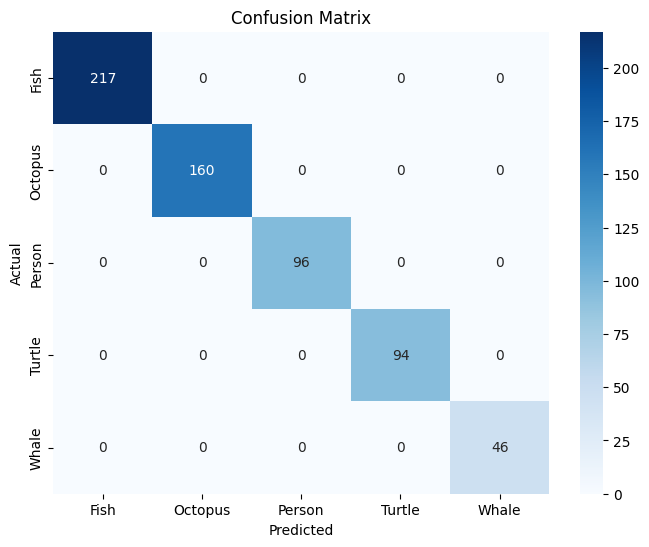

In [45]:
y_pred = np.argmax(preds, axis=1)
cm = confusion_matrix(y, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

#### Precision-Recall

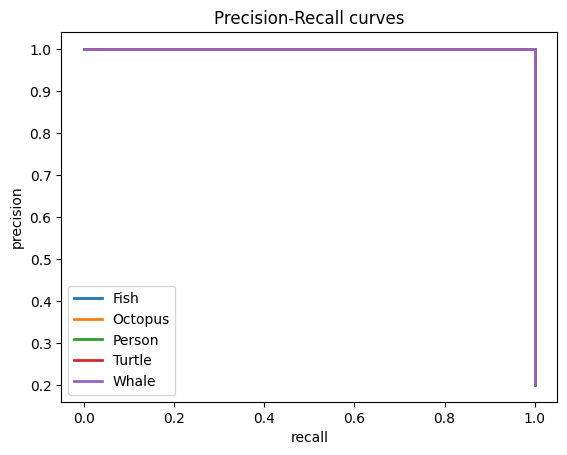

In [31]:
precision = dict()
recall = dict()
for i in range(num_classes):
    precision[i], recall[i], _ = precision_recall_curve(binary_labels[i], preds[i])
    plt.plot(recall[i], precision[i], lw=2, label=class_names[i])

plt.xlabel("recall")
plt.ylabel("precision")
plt.legend(loc="best")
plt.title("Precision-Recall curves")
plt.show()

#### F1-score

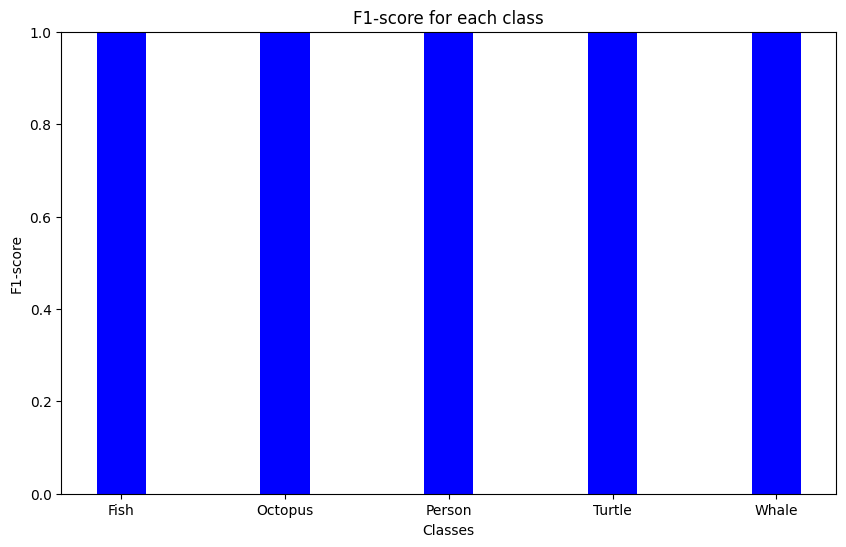

In [29]:
preds = np.array(preds)
y_pred_class = preds.argmax(axis=1)
f1_per_class = f1_score(labels, y_pred_class, average=None)
plt.figure(figsize=(10, 6))
plt.bar(class_names, f1_per_class, width=0.3, color='blue')
plt.xlabel('Classes')
plt.ylabel('F1-score')
plt.title('F1-score for each class')
plt.xticks(class_names)
plt.ylim(0, 1)

plt.show()

#### Preparazione di resenet18 per l'estrazione di features

In [5]:
# Caricamento di resnet18 per l'estrazione di features

model = models.resnet18(weights=None)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 5)
model.load_state_dict(torch.load("my_resnet_model.pt", map_location='cpu'))

model = nn.Sequential(*list(model.children()))[:-1]
model.eval()

Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Con

La seguente funzione utilizza resnet18 per ricavare il descrittore dell'immagine

In [6]:
def appearance_descriptor(image):
    with torch.no_grad():
        features = model(image.unsqueeze(0))

        features = torch.reshape(features, (-1,))

        # Normalizziamo il vettore
        sum = features.sum()
        ft_norm = features/sum

        ft_norm = ft_norm.numpy()

        return ft_norm


### DeepSORT

Alcune funzioni ausiliari che saranno utili nell'elaborazione dei dati

In [7]:
# mean = [x_center, y_center, aspect_ratio, height, Vx, Vy, Va, Vh] -> [x_min, y_min, width, height]
def xy_min_wh(mean):
    x_center, y_center = mean[0], mean[1]
    aspect_ratio, height = mean[2], mean[3]

    width = aspect_ratio * height
    x_min, y_min = x_center - (width/2), y_center - (height/2)
    new_bbox = np.array([x_min, y_min, width, height])
    
    return new_bbox

In [8]:
# bbox = [x_min, y_min, x_max, y-max] -> [x_center, y_center, a, height]
def xy_center_ah(bbox):
    x_min, y_min = bbox[0], bbox[1]
    x_max, y_max = bbox[2], bbox[3]

    width = x_max - x_min
    height = y_max - y_min

    x_center = x_min + width/2
    y_center = y_min + height/2     

    aspect_ratio = width/height    

    new_bbox = bbox.copy()
    new_bbox[0] = x_center
    new_bbox[1] = y_center
    new_bbox[2] = aspect_ratio
    new_bbox[3] = height

    return new_bbox


In [9]:
def crop_image(image, bbox):
    # bbox = [x_min. y_min, x_max, y_max]
    x_min, y_min = bbox[0], bbox[1]
    x_max, y_max = bbox[2], bbox[3]

    _, im_height, im_width = image.shape

    if x_min < 0 or y_min < 0 or x_max >= im_width or y_max >= im_height or x_max - x_min <= 0 or y_max - y_min <= 0:
        # in questo caso non c'è stata nessuna rilevazione e quindi lanciamo un errore
        return image 
    
    cropped_image = image[:, y_min:y_max, x_min:x_max]

    return cropped_image


#### Kalman Filter

In [10]:
INFTY_COST = 1e+5

In [11]:
""" 
Dizionario in cui sono salvati i valori dell'inverso del chi-quadro
"""

chi2inv95 = {
    1: 3.8415,
    2: 5.9915,
    3: 7.8147,
    4: 9.4877,
    5: 11.070,
    6: 12.592,
    7: 14.067,
    8: 15.507,
    9: 16.919
}

class KalmanFilter:
    def __init__(self):
        ''' Per semplicita consideriamo un modello a velocità costante, quindi l'aspect ratio è costante.
            La matrice dinamica da cui possiamo prevedere il prossimo stato è una matrice 8x8
        '''

        rows = 4
        self.dynamic_matrix = np.eye(2*rows, 2*rows)
        for i in range(rows):
            self.dynamic_matrix[i, rows+i] = 1

        ''' 
        La matrice 'update_pos' è necessaria per determinare la nuova posizione dell'oggetto 
        a partire dalle coordinate del bounding box
        '''
        self.update_pos = np.eye(rows, 2*rows)

        self._std_weight_position = 1. / 20
        self._std_weight_velocity = 1. / 160

    def initiate(self, bounding_box):
        ''' 
        Crea una nuova traccia per un rilevamento senza associazione
        Bounding box (x_center, y_center, a, h) 

        '''

        # Inizializziamo le velocita a zero, avremo quindi un vettore del tipo [x_center, y_center, a, h, 0, 0, 0, 0]
        mean = bounding_box.copy()
        for i in range(4):
            mean = np.append(mean, 0)

        # Covarianza sarà una matrice che misura l'incertezza della nostra stima

        std = [
            2 * self._std_weight_position * bounding_box[3],
            2 * self._std_weight_position * bounding_box[3],
            1e-2,
            2 * self._std_weight_position * bounding_box[3],
            10 * self._std_weight_velocity * bounding_box[3],
            10 * self._std_weight_velocity * bounding_box[3],
            1e-5,
            10 * self._std_weight_velocity * bounding_box[3]
        ]

        covariance = np.diag(np.square(std))

        return mean, covariance



    def predict(self, mean, covariance):
        mean = np.dot(self.dynamic_matrix, mean)
        
        # calcolo dell'incertezza
        std_pos = [
            self._std_weight_position * mean[3],
            self._std_weight_position * mean[3],
            1e-2,
            self._std_weight_position * mean[3]]
        std_vel = [
            self._std_weight_velocity * mean[3],
            self._std_weight_velocity * mean[3],
            1e-5,
            self._std_weight_velocity * mean[3]]
        
        motion_cov = np.diag(np.square(np.r_[std_pos, std_vel]))
        
        covariance = np.linalg.multi_dot((
            self.dynamic_matrix, covariance, self.dynamic_matrix.T)) + motion_cov

        return mean, covariance
    
    def project(self, mean, covariance):
        std = [
            self._std_weight_position * mean[3],
            self._std_weight_position * mean[3],
            1e-1,
            self._std_weight_position * mean[3]
        ]
        innvoation_cov = np.diag(np.square(std))

        mean = np.dot(self.update_pos, mean)

        covariance = np.linalg.multi_dot((self.update_pos, covariance, self.update_pos.T))

        return mean, covariance + innvoation_cov


    def update(self, mean, covariance, measurement):
        # Step di correzione della predizione

        # bounding box = [x_center, y_center, a, h]
        projected_mean, projected_cov = self.project(mean, covariance)

        chol_factor, lower = scipy.linalg.cho_factor(
            projected_cov, lower=True, check_finite=False)
        kalman_gain = scipy.linalg.cho_solve(
            (chol_factor, lower), np.dot(covariance, self.update_pos.T).T,
            check_finite=False).T
        innovation = measurement - projected_mean

        new_mean = mean + np.dot(innovation, kalman_gain.T)
        new_covariance = covariance - np.linalg.multi_dot((
            kalman_gain, projected_cov, kalman_gain.T))
        return new_mean, new_covariance

        #projected_pred, projected_cov = self.project(prediction, covariance)
#
        #chol_factor, lower = scipy.linalg.cho_factor(
        #    projected_cov, lower=True, check_finite=False)
        #kalman_gain = scipy.linalg.cho_solve((chol_factor, lower), np.dot(covariance, self.update_pos.T).T, 
        #                                     check_finite=False).T
        #innovation = bounding_box - projected_pred
#
        #new_pred = prediction + np.dot(innovation, kalman_gain.T)
        #new_covariance = covariance - np.linalg.multi_dot((
        #    kalman_gain, projected_cov, kalman_gain.T))
        #
        #return new_pred, new_covariance
    
    def gating_distance(self, mean, covariance, measurements, only_position=False):
        """ 
        Funzione che calcola il quadrato della distanza di Mahalanobis
        """
        mean, covariance = self.project(mean, covariance)
        if only_position:
            mean, covariance = mean[:2], covariance[:2, :2]
            measurements = measurements[:, :2]

        cholesky_factor = np.linalg.cholesky(covariance)
        d = measurements - mean
        z = scipy.linalg.solve_triangular(cholesky_factor, d.T, lower=True, check_finite=False, overwrite_b=True)
        squared_maha = np.sum(z*z, axis= 0)

        return squared_maha



#### Intersection-over-uninion (IOU_matching)
L'obiettivo di questa funzione è trovare il miglior match fra il bounding box che rileva l'oggetto e i vari 'track' candidati. Più in concreto si vuole calcolare l'area del bbox occupata dal candidato e ovviamente maggiore è tale area e migliore è il candidato

In [12]:
def iou(bbox, candidate):
    ''' 
    bbox = [x_min, y_min, x_max, y_max]
    '''
    intersection = 0.0

    # Coordinate del bbox
    bx_min, by_min = bbox[0], bbox[1]
    bx_max, by_max = bbox[2], bbox[3]

    # Coordinate del candidato
    cx_min, cy_min = candidate[0], candidate[1]
    c_width, c_height = candidate[2], candidate[3]

    bbox_area = (bx_max - bx_min) * (by_max - by_min)
    candidate_area = c_width * c_height

    x_min = max(bx_min, cx_min)
    y_min = max(by_min, cy_min)

    x_max = min(bx_max, cx_min+c_width)
    y_max = min(by_max, cy_min+c_height)

    intersection = (x_max - x_min) * (y_max - y_min)

    return intersection / (bbox_area + candidate_area - intersection)


def iou_cost(tracks, detections):

    num_tracks = len(tracks)
    num_dets = len(detections)

    cost_matrix = np.zeros((num_tracks, num_dets))

    for i in range(num_tracks):
        if tracks[i].last_update > 1:
            cost_matrix[i, :] = INFTY_COST
            continue

        mean = tracks[i].mean
        bbox = xy_min_wh(mean)      # [x_min, y_min, e, h]
        # max_score = 0.0
        # index = -1

        for j in range(num_dets):
            candidate = detections[j]
            score = iou(bbox, candidate)
            cost_matrix[i, j] = 1. - score
        #for j in range(num_dets):
        #    candidate = detections[j]
        #    score = iou(bbox, candidate) 
        #    if score > max_score:
        #        max_score = score
        #        index = j
        #if index != -1:
        #    cost_matrix[i, index] = 1. - max_score

    return cost_matrix

#### Track

In [13]:
class TrackState:
    Tentative = 1
    Confirmed = 2
    Deleted = 3
    Suspended = 4   # MODIFICA


class Track:

    """ 
    Una traccia è composta dai seguenti attributi:
        - mean = [x_center, y_center, a, h, Vx, Vy, Va, Vh]
        - covariance: matrice 8x8 che serve a stimare l'incertezza della predizione
        - track_id: identificativo della traccia
        - n_init: numero di rilevamenti consecutivi prima che la traccia venga confermata
        - max_age: massimo numero di volte consecutive senza associazione prima che la traccia
                    venga eliminata
        - feature: descrittore del rilevamento da cui la traccia è stata originata
        - hits: numero totale di updates
    """

    def __init__(self, mean, covaraince, track_id, n_init, max_age, feature=None):
        self.mean = mean
        self.covariance = covaraince
        self.track_id = track_id
        self.n_init = n_init
        self.max_age = max_age
        self.state = TrackState.Tentative
        #self.age = 1    # Inutilizzata
        #self.class_index = class_index
        self.hits = 1
        self.last_update = 0
        self.features = []
        if feature is not None:
            self.features.append(feature)

    def predict(self, kf):
        self.mean, self.covariance = kf.predict(self.mean, self.covariance)
        # self.age += 1
        self.last_update += 1
        

    def update(self, kf, detection, img):
        # Aggiorna la traccia con una nuova rilevazione
        self.mean, self.covariance = kf.update(self.mean, self.covariance, detection)
        self.last_update = 0
        self.hits += 1
        if self.state == TrackState.Tentative and self.hits >= self.n_init:
            self.state = TrackState.Confirmed
        # MODIFICA
        elif self.state == TrackState.Suspended:
            self.state = TrackState.Confirmed

        # estraiamo l'immagine delineata dal bounding box e ne calcoliamo il descrittore
        cropped_image = crop_image(img, detection)
        feature = appearance_descriptor(cropped_image)
        self.features.append(feature)
        

    def mark_missed(self):
        # Gestisce il caso in cui la traccia non viene associata ad una rilevazione
        if self.state == TrackState.Tentative:
            self.state = TrackState.Deleted

        elif self.last_update > self.max_age:
            self.state = TrackState.Deleted
        # MODIFICA
        else:
            self.state = TrackState.Suspended

        



#### NearestNeigbhorDistanceMetric

In [14]:
def cosine_distance(a, b):
    return np.dot(a, b.T)
    #return 1. - np.dot(a, b.T)

In [15]:
def nn_cosine_distance(x, y):
    distances = cosine_distance(x, y)
    return distances.min(axis=0)

In [16]:
class NearestNeighborDistanceMetric:

    def __init__(self, metric, matching_threshold):
        
        self.metric = metric
        self.matching_threshold = matching_threshold
        self.samples = {}

    def partial_fit(self, features, targets, active_tagets):
        # Funzione che ad ogni target associa le sue features
        for feature, target in zip(features, targets):
            self.samples.setdefault(target, []).append(feature)

        self.samples = {k: self.samples[k] for k in active_tagets}


    def distance(self, features, targets):
        num_features = len(features)
        num_targets = len(targets)

        # print(self.samples)

        cost_matrix = np.zeros((num_targets, num_features))

        for i in range(num_targets):
            target = targets[i]
            cost_matrix[i, :] = self.metric(self.samples[target], features)

        #print(cost_matrix)
        return cost_matrix

#### Linear assignment

In [17]:
def min_cost_matching(distance_metric, max_distance, tracks, detections, img):

    num_tracks = len(tracks)
    num_detections = len(detections)

    cost_matrix = np.zeros((num_tracks, num_detections))
    if distance_metric == iou_cost:
        cost_matrix = distance_metric(tracks, detections)
    else:
        cost_matrix = distance_metric(tracks, detections, img)

    cost_matrix[cost_matrix > max_distance] = max_distance + 1e-5
        
    matches = []

    tracks_idx, dets_idx = linear_sum_assignment(cost_matrix)

    for row, col in zip(tracks_idx, dets_idx):
        track = tracks[row]
        det = detections[col]

        if cost_matrix[row, col] < max_distance:
            matches.append((track, det))

    return matches


In [18]:
def matching_cascade(distance_metric, max_distance, tracks, detections, Amax, img):
    # distance_metric: funzione che prende in ingresso una lista di track 
    # e una lista di rilevamento e ritorna la matrice di costo, ovvero in 
    # posizione (i, j) troviamo il costo dell'associazione fra la traccia 
    # i ed il rilevamento j

    # max_distance: associazioni con un costo maggiore di max_distance vengono scartate
    
    num_tracks = len(tracks)
    num_detections = len(detections)

    if num_tracks == 0 or num_detections == 0:
        return []
    
    M = []
    U = detections.copy()

    for n in range(Amax):

        Tn = list()
        for i in range(num_tracks):
            if tracks[i].last_update == n + 1:
                Tn.append(tracks[i])

        if len(Tn) == 0:
            continue

        matches = min_cost_matching(distance_metric, max_distance, Tn, U, img)

        matched_dets = [d for _, d in matches]

        M += matches

        matched_dets = [d for _, d in matches]

        set1 = set(tuple(arr.flatten()) for arr in U)
        set2 = set(tuple(arr.flatten()) for arr in matched_dets)
        difference = set(set1 - set2)

        if len(difference) == 0:
            break

        U = [np.array(arr) for arr in difference]


    return M
        

In [19]:
def gate_cost_matrix(cost_matrix, tracks, detections, kf, only_position=False):
    gate_dim = 0
    if only_position:
        gate_dim = 2
    else:
        gate_dim = 4

    measurements = np.array(detections)

    threshold = chi2inv95[gate_dim]
    num_tracks = len(tracks)
    for i in range(num_tracks):
        track = tracks[i]
        cost = kf.gating_distance(track.mean, track.covariance, measurements, only_position)
        cost_matrix[i, cost > threshold] = INFTY_COST

    return cost_matrix


#### Tracker

In [20]:
class Tracker:
    def __init__(self, metric, max_iou_distance=0.7, n_init=3, max_age=30):
        self.metric = metric
        self.max_iou_distance = max_iou_distance
        self.n_init = n_init 
        self.max_age = max_age
        self.tracks = []
        self.track_id = 1
        self.kf = KalmanFilter()

    def predict(self):
        # Per ogni traccia attiva nel frame attuale
        # prediciamo la sua pposizione nel frame successivo

        num_tracks = len(self.tracks)
        for i in range(num_tracks):
            self.tracks[i].predict(self.kf)
            
    def update(self, detections, img):
        # In questo step andiamo a correggere le 
        # predizioni fatte nello step precedente

        matches = self.match(detections, img)

        for track, det in matches:
            # trasformiamo le coordinate del bounding box:
            # [x_min, y_min, x_max, y_max] -> [x_center, y_center, a, h]
            measurement = xy_center_ah(det)
            track.update(self.kf, measurement, img)

        matched_tracks = [t for t, _ in matches]
        matched_dets = [d for _, d in matches]


        list1 = [tuple(arr.flatten()) for arr in matched_dets]
        list2 = [tuple(arr.flatten()) for arr in detections]
    
        unmatched_dets = [np.array(d) for d in list2 if d not in list1]

        for t in self.tracks:
            if t not in matched_tracks:
                t.mark_missed()

        for det in unmatched_dets:
            self.add_track(det, img)


        self.tracks = [t for t in self.tracks if t.state != TrackState.Deleted]

        #confirmed_tracks = [t for t in self.tracks if t.state == TrackState.Confirmed] 


        # Aggiorna distance metric

        active_targets = [t.track_id for t in self.tracks if t.state != TrackState.Deleted]
        features, targets = [], []
        for track in self.tracks:
            if track.state == TrackState.Deleted:
                continue

            features += track.features
            targets += [track.track_id for _ in track.features]
            track.features = []

        self.metric.partial_fit(np.asarray(features), np.asarray(targets), active_targets)


        
    def match(self, detections, img):

        def gated_metric(tracks, detections, img):
            # Calcoliamo la matrice dei costi relativamente alla cosine_distance
            num_tracks = len(tracks)
            num_detections = len(detections)
            cropped_images = []
            for i in range(num_detections):
                cropped_img = crop_image(img, detections[i])
                cropped_images.append(cropped_img)

            descriptors = np.array([appearance_descriptor(cropped_images[i]) for i in range(len(cropped_images))])

            targets = np.array([tracks[i].track_id for i in range(num_tracks)])
            cost_matrix = self.metric.distance(descriptors, targets)

            #print(cost_matrix)          

            # trasformiamo le coordinate del bounding box in [x_center, y_center, a, h]
            dets = [xy_center_ah(d) for d in detections]
            cost_matrix = gate_cost_matrix(cost_matrix, tracks, dets, self.kf)

            return cost_matrix
        

        
        #confirmed_tracks = [t for t in self.tracks if t.state == TrackState.Confirmed] 

        unconfirmed_tracks = [t for t in self.tracks if t.state != TrackState.Confirmed]
        
        matches = matching_cascade(gated_metric, self.metric.matching_threshold, self.tracks, detections, self.max_age, img)
    
        # self.matching_threshold è la max_cosine_distance

        # if len(matches) > 0:
        #     print("FOUND")

        matched_tracks = [t for t,_ in matches]
        matched_dets = [d for _, d in matches]

        list1 = [tuple(arr.flatten()) for arr in matched_dets]
        list2 = [tuple(arr.flatten()) for arr in detections]
    
        unmatched_dets = [np.array(d) for d in list2 if d not in list1]
        unmatched_tracks = [t for t in self.tracks if t not in matched_tracks]


        # Facciamo un ultimo tentativo di associazione per le tracce di età 1, utilizzando IOU
        new_tentative_tracks = list(set([t for t in unconfirmed_tracks if t.last_update == 1] + \
            [t for t in unmatched_tracks if t.last_update == 1]))

        new_matches = matching_cascade(iou_cost, self.max_iou_distance, new_tentative_tracks, unmatched_dets, self.max_age, img)

        total_matches = matches + new_matches

        return total_matches


    def add_track(self, detection, img):
        # inizializziamo una nuova traccia per ogni rilevamento senza associazione
        # inoltre calcoliamo un descrittore per il rileavmento da cui stiamo generando la traccia
        #class_index = detection[4]
        #detection = detection[:4]
        
        cropped_image = crop_image(img, detection)
        descriptor = appearance_descriptor(cropped_image)

        det = xy_center_ah(detection) 
        
        mean, cov = self.kf.initiate(det)
        new_track = Track(mean, cov, self.track_id, self.n_init, self.max_age, feature=descriptor)
    
        # self.class_index = class_index
        self.track_id += 1
        self.tracks.append(new_track)



#### Esecuzione di DeepSORT

In [23]:
class run_deepSORT():
    def __init__(self, video):
        self.video = video
        self.model = self.load_model()
        self.classes = self.model.model.names

    def load_model(self):
        model = YOLO('best.pt')
        #model.eval()

        return model 
    
    def predict(self, img):
        results = self.model.predict(img, verbose=False)
        return results 
    
    def get_boxes(self, results, img):
        detections = []

        for r in results:
            boxes = r.boxes
            for box in boxes:
                x_min, y_min, x_max, y_max = box.xyxy[0]

                class_index = int(box.cls[0])
                #class_name = self.classes[class_index]

                conf = box.conf[0]

                if conf > 0.5:
                    detections.append(np.array([int(x_min), int(y_min), int(x_max), int(y_max)]))    

        return detections, img
    
    def track_detect(self, detections, img, tracker):
        # prediciamo la posizione delle tracce attive
        tracker.predict()

        # trasformiamo l'immagine in un tensore
        rgb_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        pil_image = Image.fromarray(rgb_img)
        img_tensor = test_transform(pil_image)

        # associamo le predizioni ai rilevamenti
        tracker.update(detections, img_tensor)

        # Estraiamo le tracce
        tracks = tracker.tracks

        for track in tracks:
            if track.state != TrackState.Confirmed:
                continue 
         

            track_id = track.track_id 
            # class_index = track.class_index
            # name = self.classes[class_index]
            mean = track.mean
            
            #state = mean[:4]
            #print("state: ", state)

            bbox = xy_min_wh(mean)

            #print(bbox)

            x_min, y_min = int(bbox[0]), int(bbox[1])
            width, height = int(bbox[2]), int(bbox[3])

            cvzone.putTextRect(img, f'ID: {track_id}', (x_min, y_min), scale=1, thickness=1, colorR=(0,0,255))
            cvzone.cornerRect(img, (x_min, y_min, width, height), l=9, rt=1, colorR=(255,0,255))

        return img
        
    def run_tracker(self):
        cap = cv2.VideoCapture(self.video)

        max_cosine_distance = 0.2 # Default(0.2)

        metric = NearestNeighborDistanceMetric(nn_cosine_distance, max_cosine_distance)

        tracker = Tracker(metric)

        while cap.isOpened():
            ret, img = cap.read()

            if ret == True:

                results = self.predict(img)
                detections, frame = self.get_boxes(results, img)
                # print(detections)
                detect_frame = self.track_detect(detections, frame, tracker)

                cv2.imshow('Image', detect_frame)
                if cv2.waitKey(1) == ord('q'):
                    break

        cap.release()
        cv2.destroyAllWindows()



In [ ]:
tracker = run_deepSORT("Tracking_test/Ballena/Ballena.mp4")
tracker.run_tracker()

In [ ]:
tracker = run_deepSORT("Tracking_test/Octopus2/Octopus2.mp4")
tracker.run_tracker()

In [ ]:
tracker = run_deepSORT("Tracking_test/Turtle/SeaTurtle3.mp4")
tracker.run_tracker()

In [ ]:
tracker = run_deepSORT("Tracking_test/Person/ArmyDiver2.mp4")
tracker.run_tracker()